In [3]:
# !pip install darts
# !pip install -U kaleido


## **Step 1: Import all the libraries and modules**

In [44]:
import pandas as pd
import numpy as np
import os
import sys

%load_ext autoreload
%autoreload 2

target_dir = os.path.abspath(os.path.join(os.getcwd(), '..' ))
sys.path.append(target_dir)
          
from Models.XGBOOST.XGBBOOSTModel import xgboost_model
from Models.XGBOOST.xgb_evaluation import evaluation_of_model_xgb_Model
from Models.XGBOOST.xgb_evaluation import load_model_xgb_model
from Models.ARIMAModel.preprocessing import preprocess_df_to_ts
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
import logging
from tqdm import tqdm
import gc
from darts.models.forecasting.xgboost import  XGBModel
import itertools
import sys
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Step 2 : Reading Data Daily Traffic Accident Forecasting**

In [45]:
daily_traffic_accident_data_path = '../data/processed/daily_data.csv'
daily_accident_df = pd.read_csv(daily_traffic_accident_data_path)
daily_accident_df

,daily,daily_accident
0,2018-01-01,234
1,2018-01-02,408
2,2018-01-03,231
3,2018-01-04,225
4,2018-01-05,342
...,...,...
1821,2022-12-27,183
1822,2022-12-28,177
1823,2022-12-29,191
1824,2022-12-30,193


## **Step 3 : Split the Data into train and test data**

In [46]:
processed_train_df, processed_test_df = train_test_split(
        daily_accident_df, test_size=0.245, random_state=42, shuffle=False)

## **Step 4 : Preprocess the data into Time series object**

In [47]:
print('[INFO] Converting data into times series types')
ts_train = preprocess_df_to_ts(processed_train_df,'daily','daily_accident','1D')
ts_test = preprocess_df_to_ts(processed_test_df,'daily','daily_accident','1D')

[INFO] Converting data into times series types


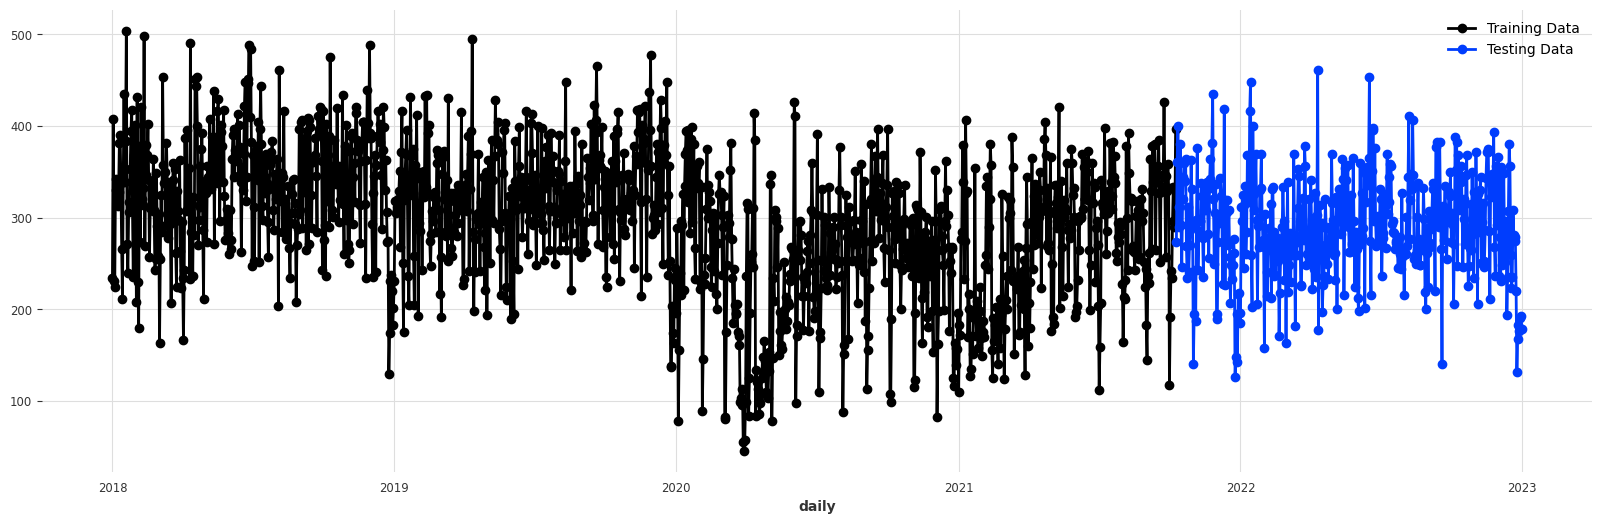

In [55]:
plt.figure(figsize=(20,6))
ts_train.plot(marker='o',label='Training Data')
ts_test.plot(marker='o',label='Testing Data')
plt.show()

## **Step 5 : Training the Model**

### **Grid Search Algorithm**

In [48]:
# minimum_aicc = 0
# best_mape = np.inf  # Initialize best AIC value to positive infinity
# best_params = None  # Initialize best parameters to None

# parent_dir_for_saivng_trained_model_files = os.path.join("..","pkl")
# os.makedirs(parent_dir_for_saivng_trained_model_files,exist_ok=True)
# filename = 'xgbmodel'

#     # Load or initialize the list of trained model filenames
# trained_model_filenames = []
# trained_model_filenames_file = os.path.join(
#     parent_dir_for_saivng_trained_model_files, "trained_model_filenames.txt"
# )

# if os.path.exists(trained_model_filenames_file):
#     with open(trained_model_filenames_file, "r") as file:
#         trained_model_filenames = file.read().splitlines()

# lags_value = [10,20,30,40,50]
# output_chunk_lenghts_value = [12,24,48,60,72]
# multi_models_value = [True,False]
# use_static_covariates_value = [True,False]
# likelihood_value = ['poisson','quantile']
# quantiles_value = [[0.2, 0.5, 0.8], [0.35, 0.5, 0.65], [0.4, 0.5, 0.6]]

# param_combinations = list(
#     itertools.product(lags_value,
#                       output_chunk_lenghts_value,
#                       multi_models_value, 
#                       use_static_covariates_value, 
#                       likelihood_value, 
#                       quantiles_value))

# param_combinations_bar = tqdm(param_combinations, desc="Parameter combinations")

# # Iterate through all combinations
# for params in param_combinations_bar:
#     lags, output_chunk_length ,multi_models ,use_static_covariates ,likelihood ,quantiles = params 
    
#     print(f"Iteration file : {params}")
    
#     model_parapmeter_name = f"Trying parameters: lags={lags}, output_chunk_length={output_chunk_length}, multi_models={multi_models}, use_static_covariates={use_static_covariates}, quantiles={quantiles}, quantiles={quantiles}"
#     model_file_name = f'{filename}_{model_parapmeter_name}.pkl'

    
#     # Construct the file path for the trained model
#     trained_model_file_name = os.path.join(parent_dir_for_saivng_trained_model_files,model_file_name)
            
    
#     # Skip if the file already exists or is in the list of trained model filenames
#     # if model_file_name in trained_model_filenames:
#     #     print(f"Model for parameters {params} already trained, skipping...")
#     #     continue

#     try:

#         print('Training the Models')
    
#         xgbmodel = xgboost_model(
#                             series=ts_train,
#                             lags=lags,
#                             output_chunk_length=output_chunk_length,
#                             multi_models=multi_models,
#                             use_static_covariates=use_static_covariates,
#                             likelihood =  likelihood,
#                               quantiles = quantiles)


        
#         forecasted_values = xgbmodel.predict(60)
#         actual = ts_test[0:60].values()
#         predicted = forecasted_values.values()
#         mape = np.mean(np.abs((predicted - actual) / actual)) * 100

        
#         # Check if current AIC value is lower than the best AIC value found so far
#         if mape < best_mape:
#             print(f"AIC for parameters {params}: {mape}")
#             print(f'Best Parameters till now : {params}')
#             best_mape = mape
#             best_params = params
        
        
#     except Exception as e:
#         print(f'Error has occurred : {e}')
        
#         trained_model_filenames.append(model_file_name)  # Add filename to the list

#         # Append the filename to the text file
#         with open(trained_model_filenames_file, "a") as file:
#             file.write(model_file_name + "\n")

#         continue
#     # break
# # Print the best parameters found
# print(f"Best parameters based on AIC: {best_params}")


In [49]:
import glob as gb
list_of_trained_best_models = gb.glob(f"{os.path.join('..','pkl')}/*.pkl")
list_of_trained_best_models

lags = 40
output_chunk_length = 60
multi_models = False # True
use_static_covariates = True # True
likelihood = 'quantile' #'poisson' # quantile
quantiles = [0.2, 0.5, 0.8]

trained_model_file_name = f"{os.path.join('..','pkl')}/XGBoost_lags_{lags}_output_chunk_length_{output_chunk_length}_multi_models_{multi_models}_use_static_covariates_{use_static_covariates}_likelihood_{likelihood}_quantiles_{quantiles}.pkl"

if trained_model_file_name in list_of_trained_best_models:
    print('Loading the pre-trained Model')
    xgbmodel = XGBModel.load(trained_model_file_name)
else:
    print('Training the Models')

    xgbmodel = xgboost_model(
                        series=ts_train,
                        lags=lags,
                        output_chunk_length=output_chunk_length,
                        multi_models=multi_models,
                        use_static_covariates=use_static_covariates,
                        likelihood =  likelihood,
                          quantiles = quantiles
                        )
    xgbmodel.save(trained_model_file_name)

    

Loading the pre-trained Model


## **Step 6 : Loading the Trained Model**

In [50]:
xgbmodel = load_model_xgb_model(trained_model_file_name)

## **Step 7 : Evaluation of the XGB Model**

Evaluation of input window : 60 & Horizon : 388
[ERROR] occurred at evaluation_of_model_xgb_Model  index -99 is out of bounds for axis 1 with size 60
Evaluation of input window : 120 & Horizon : 328
metrics: {'MAE': 49.11, 'RMSE': 61.22, 'MAPE': 17.8, 'MSE': 3747.98}


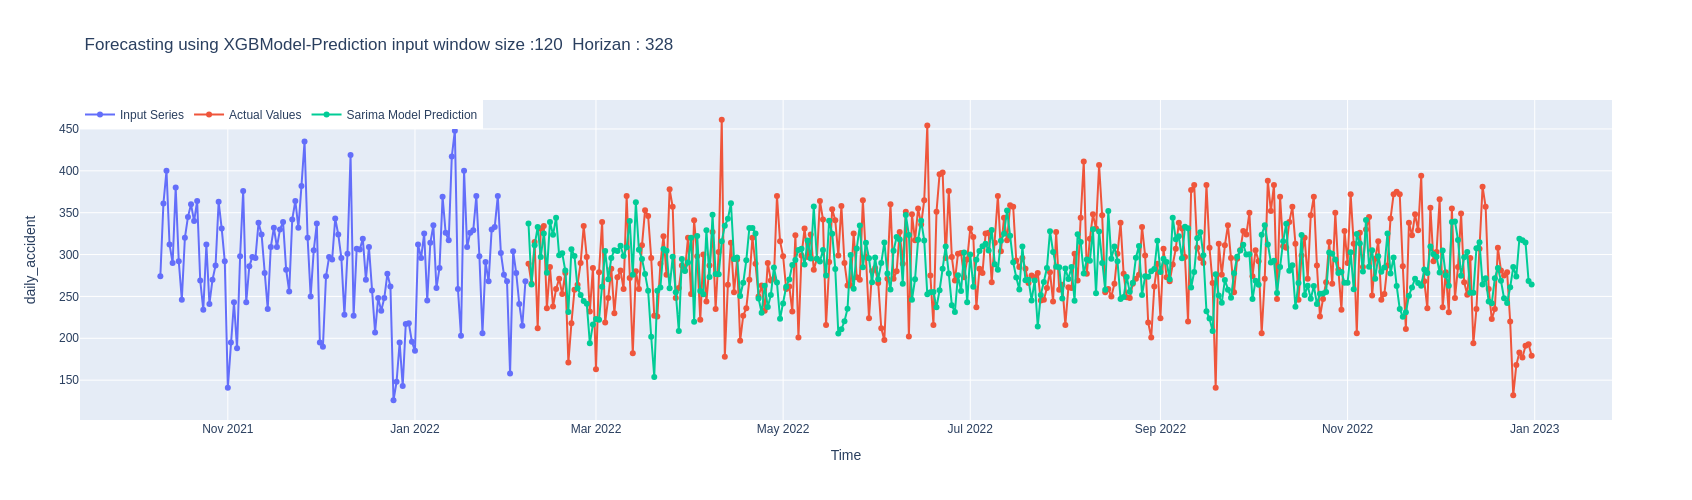

Evaluation of input window : 180 & Horizon : 268
metrics: {'MAE': 41.63, 'RMSE': 54.08, 'MAPE': 14.31, 'MSE': 2924.34}


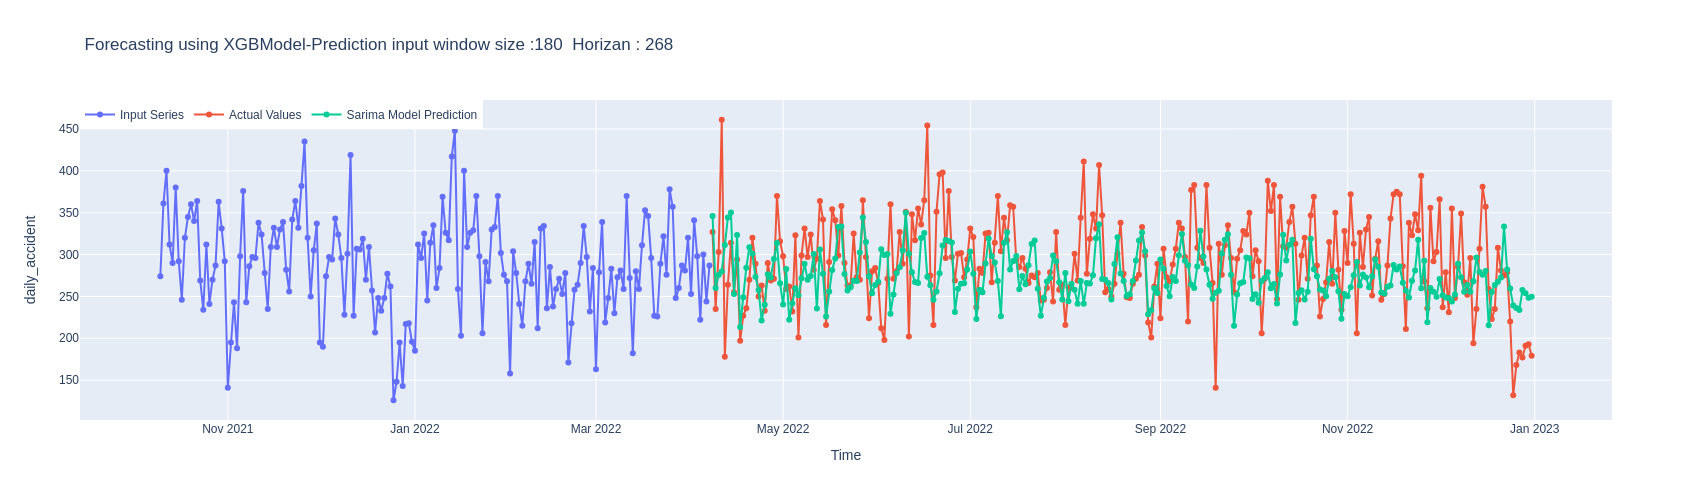

Evaluation of input window : 240 & Horizon : 208
metrics: {'MAE': 43.58, 'RMSE': 54.92, 'MAPE': 15.34, 'MSE': 3016.25}


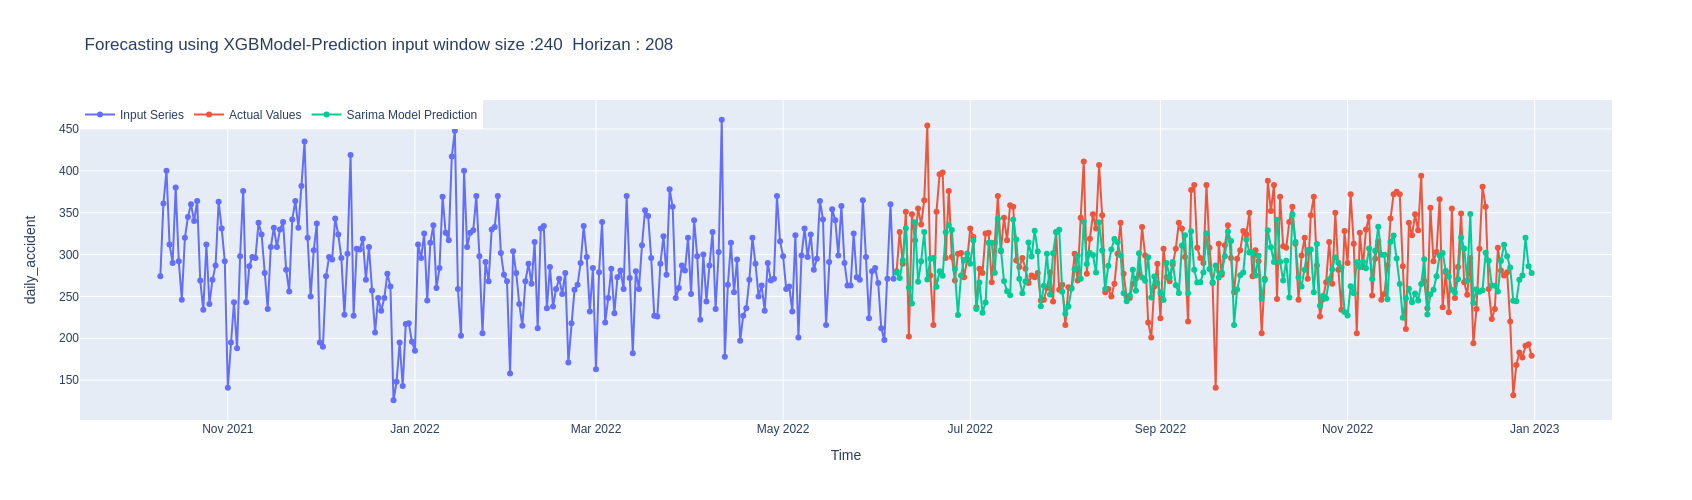

Evaluation of input window : 300 & Horizon : 148
metrics: {'MAE': 45.17, 'RMSE': 57.37, 'MAPE': 17.71, 'MSE': 3291.82}


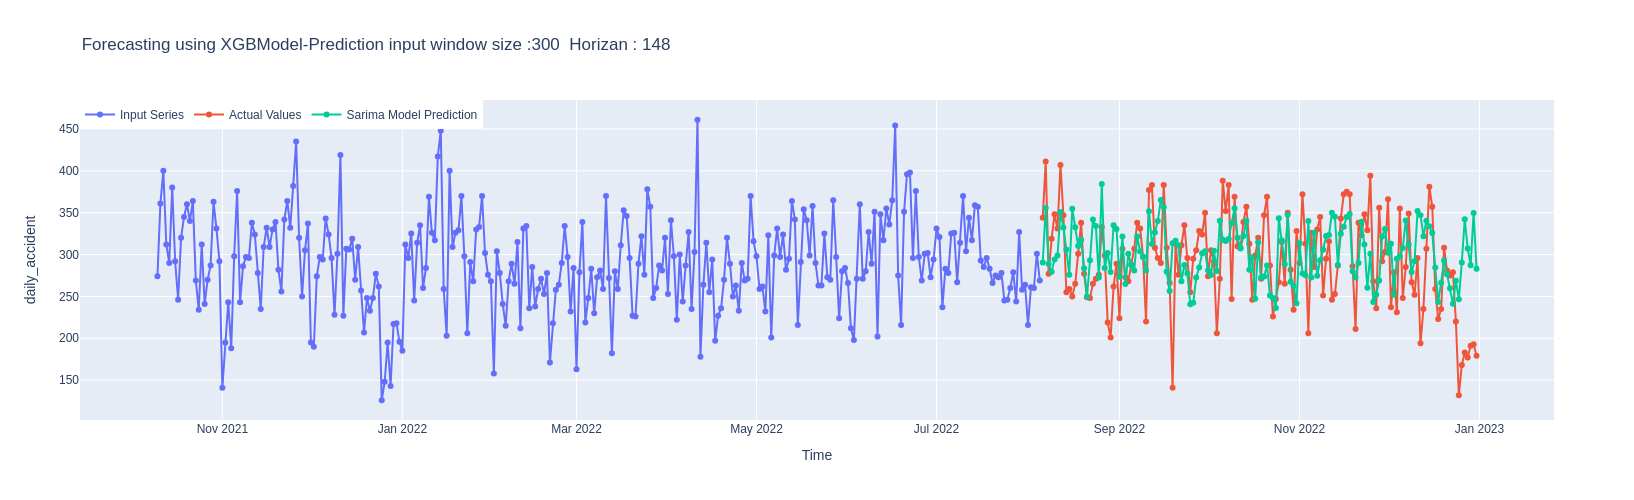

0

In [51]:
evaluation_xgb_df = evaluation_of_model_xgb_Model(trained_model_file_name,
                                                    ts_test=ts_test,
                                                    ts_train=ts_train)

evaluation_xgb_df
gc.collect()

## **Step 8 : Saving the Statistical Results**

In [53]:
print('[INFO] Generating Statistical Results of XGB Model')
statistical_result_save_path = os.path.join("../StatisticalResults")
os.makedirs(statistical_result_save_path,exist_ok=True)

evaluation_xgb_df.to_csv(
f"{statistical_result_save_path}/xgb_evaluation_results.csv", index=False
)

[INFO] Generating Statistical Results of XGB Model


In [54]:
evaluation_xgb_df

,input_window_in_hours,output_window_in_hours,MAE,RMSE,MAPE,MSE
0,120,328,49.11,61.22,17.80,3747.98
1,180,268,41.63,54.08,14.31,2924.34
2,240,208,43.58,54.92,15.34,3016.25
3,300,148,45.17,57.37,17.71,3291.82
